### Libs imports

In [1]:
# Execute extenttion to reload files in project dir
%load_ext autoreload
%autoreload 2

In [2]:
# Add link to project root
import sys, os
sys.path.append(os.path.abspath('..'))

In [16]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from time import sleep

from source.data.get.binance_prices import get_binance_symbols, get_candles_spot_binance, compose_binance_candles_df
from source.data.process.compose_features import add_features
import config

import matplotlib

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

### Get data

In [5]:
BINANCE_SYMBOLS = get_binance_symbols(only_usdt=True)
# candels_df = compose_binance_candles_df(BINANCE_SYMBOLS, start_time='2018-01-01')
# candels_df
# Get binance data
candles_df = pd.read_csv(os.path.join(config.PRICES_PATH, "binance_data.csv"), index_col=0, sep=",")
candles_df.index = candles_df.index.map(lambda x: pd.Timestamp(x, tz="Europe/Moscow"))

In [42]:
from source.model.train import prepare_data_sets, train_model, calculate_model_metrics 

xgb_params = {
    "colsample_bytree": [0.7, 0.3],
    "gamma": [0, 0.5],
    "learning_rate": [0.1, 0.03, 0.003], # default 0.1 
    "max_depth": [2, 6], # default 3
    "n_estimators": [100, 300, 600], # default 100
    "subsample": [0.6, 0.4]
}

EXPERIMENT_CONFIG = {
    'features': {
        "symbol_features": {
            "calculate_supertrend": [["SuperTrend"], {"vol_func": "atr", "period": 20, "multiplier": 2.5}],
            "calculate_macd": [
                ["MACD_Signal_Line", "MACD", "MACD_Bar_Charts"],
                {"short_period": 12, "long_period": 26, "smoothing_period": 9}
            ],
            "calculate_rsi": [["RSI"], {"period": 20, "ema": True}],
            "calculate_obv_to_volume_ratio": [["OBV_Volume_Ratio"], {}],
            "distance_between_bb_bands": [
                ["Upper_distance", "Lower_distance"],
                {"period": 20, "multiplier": 2.5, "ema": 2.5, "normalize": True}
            ],
            "calculate_cmf": [["CMF"], {"period": 20}],
            "calculate_price_rate_of_change": [["Price_ROC"], {}],
            "calculate_volume_rate_of_change": [["Volume_ROC"], {}],
            "calculate_volume_ratio": [["Volume_Ratio"], {"period": 20, "ema": True}],
            "calculate_stoch_rsi": [
                ["Stoch_RSI_K", "Stoch_RSI_D"],
                {"rsi_period": 20, "k_period": 20, "smooth_k": 5, "smooth_k": 5, "ema": True}
            ],
            "calculate_trailing_linear_reg_params": [["Reg_Coef", "RMSE"], {"period": 25, "col_name": "cum_prod"}],
            "calculate_fibonacci_levels": [
                ["fibo_23.6", "fibo_38.2", "fibo_50", "fibo_61.8", "fibo_100"],
                {"period": 21, "type_deal": "long"}
            ]
        },
        "dates_features": {
            "calculate_fear_and_greed_index": [["fear_and_greed"], {}],
            "calculate_dominance": [["btc_dominance", "eth_dominance"], {}],
            "calculate_btc_features": [
                [
                    'btc_SuperTrend', 'btc_MACD_Signal_Line', 'btc_MACD', 'btc_MACD_Bar_Charts', 'btc_RSI',
                    'btc_OBV_Volume_Ratio', 'btc_Upper_distance', 'btc_Lower_distance', 'btc_CMF', 'btc_Price_ROC',
                    'btc_Volume_ROC', 'btc_Volume_Ratio', 'btc_Stoch_RSI_K', 'btc_Stoch_RSI_D', 'btc_Reg_Coef',
                    'btc_RMSE'
                ],
                {}
            ]
        }
    },
    'strategy_params': {
        "last_features_window": 7,
        "candles_between_pump": 25,
        "validation_window": 20,  # candles
        "min_yield": -20,  # %
        "max_yield": 20,  # %
        "first_yield": 3  # %
    },
    'data_processing': {
        "sample_multiplier": 2.5
    }
}


x_train, x_test, y_train, y_test = prepare_data_sets(candles_df, EXPERIMENT_CONFIG, split_coef=0.8)

model = train_model(x_train, y_train, xgb_params, model_name=None)

predict = calculate_model_metrics(model, x_test, y_test, proba=False)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.64it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.70      0.88      0.78        24
           1       0.25      0.10      0.14        10

    accuracy                           0.65        34
   macro avg       0.47      0.49      0.46        34
weighted avg       0.57      0.65      0.59        34

accuracy:  0.6470588235294118
[[21  3]
 [ 9  1]]


In [ ]:
from source.plots import plot_confusion_matrix, plot_feature_importance

plot_confusion_matrix(y_test, predict, classes=[0, 1])
plot_feature_importance(model, x_test, y_test)

In [28]:
display(train_set["class"].value_counts())
print('\nDataset stucture:')
display(train_set.groupby(['class', 'data_type']).Symbol.count())

class
0    8837
1    3577
Name: count, dtype: int64


Dataset stucture:


class  data_type                  
0      first_yield>3_cum_prod<0       2447
       first_yield>3_cum_prod>0<20    6390
1      first_yield>3_cum_prod>20      3577
Name: Symbol, dtype: int64

## Eval

In [63]:
from datetime import date, timedelta

'2023-12-05'

In [374]:
BINANCE_SYMBOLS = get_binance_symbols(only_usdt=True)
DAYS_BEFORE = 30

DATE_BEFORE_TODAY = (date.today() - timedelta(days=DAYS_BEFORE)).strftime("%Y-%m-%d")
eval_candels_df = compose_binance_candles_df(BINANCE_SYMBOLS, start_time=DATE_BEFORE_TODAY)
eval_candels_df.head()

  0%|          | 0/494 [00:00<?, ?it/s]

,Open,High,Low,Close,Volume,Symbol
Time,,,,,,
2023-12-06 03:00:00+03:00,44073.82,44297.21,43335.28,43762.69,51431.10492,BTCUSDT
2023-12-07 03:00:00+03:00,43762.69,44047.33,42821.10,43273.14,47103.26845,BTCUSDT
2023-12-08 03:00:00+03:00,43273.15,44700.00,43081.10,44170.99,42900.37556,BTCUSDT
2023-12-09 03:00:00+03:00,44171.00,44358.02,43584.51,43713.60,24925.97008,BTCUSDT
2023-12-10 03:00:00+03:00,43713.59,44049.00,43563.00,43789.51,18956.61758,BTCUSDT


In [378]:
eval_features_df = add_features(eval_candels_df, EXPERIMENT_CONFIG)
eval_features_df.head()

  0%|          | 0/392 [00:00<?, ?it/s]

,Open,High,Low,Close,Volume,Symbol,cum_prod,yield_before_pump,Trailing_ATR,SuperTrend,MACD,MACD_Signal_Line,MACD_Bar_Charts,RSI,OBV_Volume_Ratio,Upper_distance,Lower_distance,CMF,Price_ROC,Volume_ROC,Volume_Ratio,Stoch_RSI_K,Stoch_RSI_D,Reg_Coef,RMSE,SuperTrend_lag_1,SuperTrend_lag_2,SuperTrend_lag_3,SuperTrend_lag_4,SuperTrend_lag_5,SuperTrend_lag_6,SuperTrend_lag_7,MACD_Signal_Line_lag_1,MACD_Signal_Line_lag_2,MACD_Signal_Line_lag_3,MACD_Signal_Line_lag_4,MACD_Signal_Line_lag_5,MACD_Signal_Line_lag_6,MACD_Signal_Line_lag_7,MACD_lag_1,MACD_lag_2,MACD_lag_3,MACD_lag_4,MACD_lag_5,MACD_lag_6,MACD_lag_7,MACD_Bar_Charts_lag_1,MACD_Bar_Charts_lag_2,MACD_Bar_Charts_lag_3,MACD_Bar_Charts_lag_4,MACD_Bar_Charts_lag_5,MACD_Bar_Charts_lag_6,MACD_Bar_Charts_lag_7,RSI_lag_1,RSI_lag_2,RSI_lag_3,RSI_lag_4,RSI_lag_5,RSI_lag_6,RSI_lag_7,OBV_Volume_Ratio_lag_1,OBV_Volume_Ratio_lag_2,OBV_Volume_Ratio_lag_3,OBV_Volume_Ratio_lag_4,OBV_Volume_Ratio_lag_5,OBV_Volume_Ratio_lag_6,OBV_Volume_Ratio_lag_7,Upper_distance_lag_1,Upper_distance_lag_2,Upper_distance_lag_3,Upper_distance_lag_4,Upper_distance_lag_5,Upper_distance_lag_6,Upper_distance_lag_7,Lower_distance_lag_1,Lower_distance_lag_2,Lower_distance_lag_3,Lower_distance_lag_4,Lower_distance_lag_5,Lower_distance_lag_6,Lower_distance_lag_7,CMF_lag_1,CMF_lag_2,CMF_lag_3,CMF_lag_4,CMF_lag_5,CMF_lag_6,CMF_lag_7,Price_ROC_lag_1,Price_ROC_lag_2,Price_ROC_lag_3,Price_ROC_lag_4,Price_ROC_lag_5,Price_ROC_lag_6,Price_ROC_lag_7,Volume_ROC_lag_1,Volume_ROC_lag_2,Volume_ROC_lag_3,Volume_ROC_lag_4,Volume_ROC_lag_5,Volume_ROC_lag_6,Volume_ROC_lag_7,Volume_Ratio_lag_1,Volume_Ratio_lag_2,Volume_Ratio_lag_3,Volume_Ratio_lag_4,Volume_Ratio_lag_5,Volume_Ratio_lag_6,Volume_Ratio_lag_7,Stoch_RSI_K_lag_1,Stoch_RSI_K_lag_2,Stoch_RSI_K_lag_3,Stoch_RSI_K_lag_4,Stoch_RSI_K_lag_5,Stoch_RSI_K_lag_6,Stoch_RSI_K_lag_7,Stoch_RSI_D_lag_1,Stoch_RSI_D_lag_2,Stoch_RSI_D_lag_3,Stoch_RSI_D_lag_4,Stoch_RSI_D_lag_5,Stoch_RSI_D_lag_6,Stoch_RSI_D_lag_7,Reg_Coef_lag_1,Reg_Coef_lag_2,Reg_Coef_lag_3,Reg_Coef_lag_4,Reg_Coef_lag_5,Reg_Coef_lag_6,Reg_Coef_lag_7,RMSE_lag_1,RMSE_lag_2,RMSE_lag_3,RMSE_lag_4,RMSE_lag_5,RMSE_lag_6,RMSE_lag_7
Time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-12-07 03:00:00+03:00,99.294071,99.435901,98.813484,98.881353,47103.26845,BTCUSDT,0.0,2.074844,0.622417,102.052064,0.000000,0.000000,0.000000,71.467109,0.000000,0.916837,0.165337,-1.940342,2.074844,-8.922720,1.000000,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-08 03:00:00+03:00,98.183343,100.909290,99.413457,100.932987,42900.37556,BTCUSDT,0.0,2.074844,0.756276,102.052064,0.163663,0.032733,0.130930,71.467109,1.000000,0.916837,0.165337,-1.940342,2.074844,-8.922720,0.918579,NaN,NaN,0.0,0.0,102.052064,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,71.467109,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.916837,NaN,NaN,NaN,NaN,NaN,NaN,0.165337,NaN,NaN,NaN,NaN,NaN,NaN,-1.940342,NaN,NaN,NaN,NaN,NaN,NaN,2.074844,NaN,NaN,NaN,NaN,NaN,NaN,-8.922720,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-09 03:00:00+03:00,100.220494,100.137277,100.575120,99.887827,24925.97008,BTCUSDT,0.0,2.074844,0.760032,102.052064,0.206649,0.067516,0.139133,71.467109,0.721112,0.916837,0.165337,-1.940342,-1.035499,-41.898014,0.558515,NaN,NaN,0.0,0.0,102.052064,102.052064,Na

In [379]:
eval_features_df_today = eval_features_df.loc[eval_features_df.index.max()].copy()
eval_features_df_today.loc[:, 'proba'] = model.best_estimator_.predict_proba(eval_features_df_today.loc[:, model.feature_names_in_])[:, 1]
eval_features_df_today.loc[:, 'predict'] = model.best_estimator_.predict(eval_features_df_today.loc[:, model.feature_names_in_])

In [380]:
best_symbols = eval_features_df_today.loc[eval_features_df_today.predict ==1 ,['Symbol', 'predict', 'proba']].sort_values('proba', ascending=False).head(50)
best_symbols

,Symbol,predict,proba
Time,,,
2024-01-05 03:00:00+03:00,LOOMUSDT,1,0.702757
2024-01-05 03:00:00+03:00,HIFIUSDT,1,0.679492
2024-01-05 03:00:00+03:00,VICUSDT,1,0.648866
2024-01-05 03:00:00+03:00,RPLUSDT,1,0.639488
2024-01-05 03:00:00+03:00,ATAUSDT,1,0.508893


In [ ]:
# # Plot one
# for symb in best_symbols.Symbol.values:
#     symb_candels = eval_candels_df[eval_candels_df.Symbol == symb]
#     symb_proba = int(best_symbols[best_symbols.Symbol == symb].proba.values[0] * 100) / 100
    
#     min_price = symb_candels.Close.min()
#     max_price = symb_candels.Close.max()
#     yield_before = int((max_price / min_price - 1) * 100)
    
#     symb_candels.Close.plot()
#     plt.title(f'{symb} Prices | proba {symb_proba} | yield before {yield_before}%')
#     plt.xlabel('Date')
#     plt.ylabel('Price (USD)')
#     plt.grid(True)
#     plt.axhline(y=(min_price), color='red')
#     plt.axhline(y=(max_price), color='red')
#     plt.xticks(rotation=45)
#     plt.tight_layout()
#     plt.show()

In [424]:
from io import BytesIO

def create_plot_best_symbols(eval_candels_df, best_symbols, show=False):

    # Create a figure with 2 rows and 5 columns for subplots
    n_rows = np.ceil(best_symbols.shape[0] / 5).astype(int)
    fig, axes = plt.subplots(nrows=n_rows, ncols=5, figsize=(20, n_rows * 4))

    # Flatten the 2D array of axes to easily iterate through them
    axes = axes.flatten()

    for i, symb in enumerate(best_symbols.Symbol.values[:4]):
        symb_candels = eval_candels_df[eval_candels_df.Symbol == symb]
        symb_proba = int(best_symbols[best_symbols.Symbol == symb].proba.values[0] * 100) / 100
        
        min_price = symb_candels.loc[symb_candels.index.min(), 'Close']
        max_price = symb_candels.loc[symb_candels.index.max(), 'Close']
        yield_before = int((max_price / min_price - 1) * 100)
        
        # Get the respective axis for the current subplot
        ax = axes[i]
        
        symb_candels.Close.plot(ax=ax)
        ax.set_title(f'{symb} Prices | proba {symb_proba} | yield before {yield_before}%', size=10, color='black', fontweight="bold")
        ax.set_xlabel(None)
        ax.set_ylabel('Price (USD)')
        ax.grid(True)
        ax.axhline(y=min_price, color='red')
        ax.axhline(y=max_price, color='green')
        ax.tick_params(axis='x', rotation=45)
        plt.tight_layout()

    # Hide any empty subplots if there are fewer than 10 symbols
    for i in range(len(best_symbols.Symbol.values), n_rows * 5):
        axes[i].axis('off')

    # Display the entire figure containing all subplots
    if show:
        plt.show()
    else:
        # Save the plot as a PNG image
        img_buffer = BytesIO()
        plt.savefig(img_buffer, format='png')
        img_buffer.seek(0)
        plt.close()
        return img_buffer


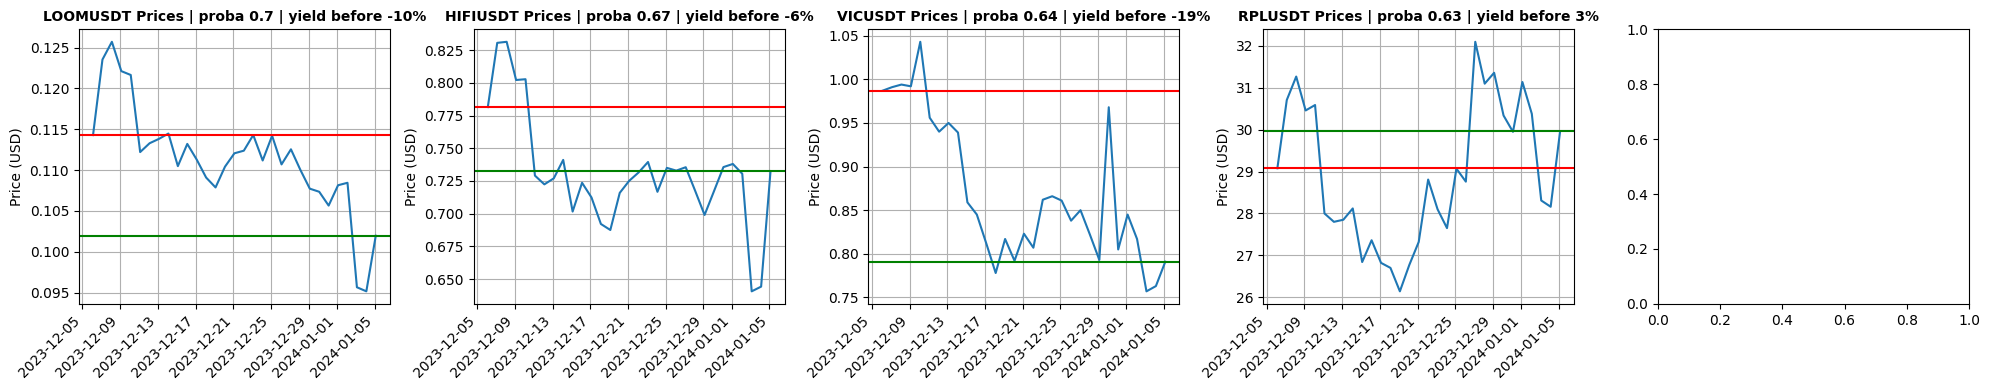

In [427]:
plots_buffer = create_plot_best_symbols(eval_candels_df, best_symbols, show=True)

In [428]:
def eval_model(exp_config=EXPERIMENT_CONFIG):

    # Get data
    print('Start to get candels')
    BINANCE_SYMBOLS = get_binance_symbols(only_usdt=True)
    DAYS_BEFORE = 30
    DATE_BEFORE_TODAY = (date.today() - timedelta(days=DAYS_BEFORE)).strftime("%Y-%m-%d")
    eval_candels_df = compose_binance_candles_df(BINANCE_SYMBOLS, start_time=DATE_BEFORE_TODAY)
    
    
    # Generate features
    print('Start to generate features')
    eval_features_df = add_features(eval_candels_df, exp_config)
    
    
    # Load model
    model = load(os.path.join(config.MODELS_PATH, "xgb_model_new.joblib"))
    
    # Predict for today
    print('Start to predict')
    eval_features_df_today = eval_features_df.loc[eval_features_df.index.max()].copy()
    eval_features_df_today.loc[:, 'proba'] = model.best_estimator_.predict_proba(eval_features_df_today.loc[:, model.feature_names_in_])[:, 1]
    eval_features_df_today.loc[:, 'predict'] = model.best_estimator_.predict(eval_features_df_today.loc[:, model.feature_names_in_])
    
    # Find best symbols
    N_BEST_SYMBOLS = 50
    best_symbols = (eval_features_df_today.loc[eval_features_df_today.predict ==1 ,['Symbol', 'predict', 'proba']]
                                         .sort_values('proba', ascending=False)
                                         .head(N_BEST_SYMBOLS)
                   )
    
    # Make plots
    plots_buffer = create_plot_best_symbols(eval_candels_df, best_symbols, show=True)
    
    return plots_buffer

Start to get candels


  0%|          | 0/494 [00:00<?, ?it/s]

Start to generate features


  0%|          | 0/392 [00:00<?, ?it/s]

Start to predict


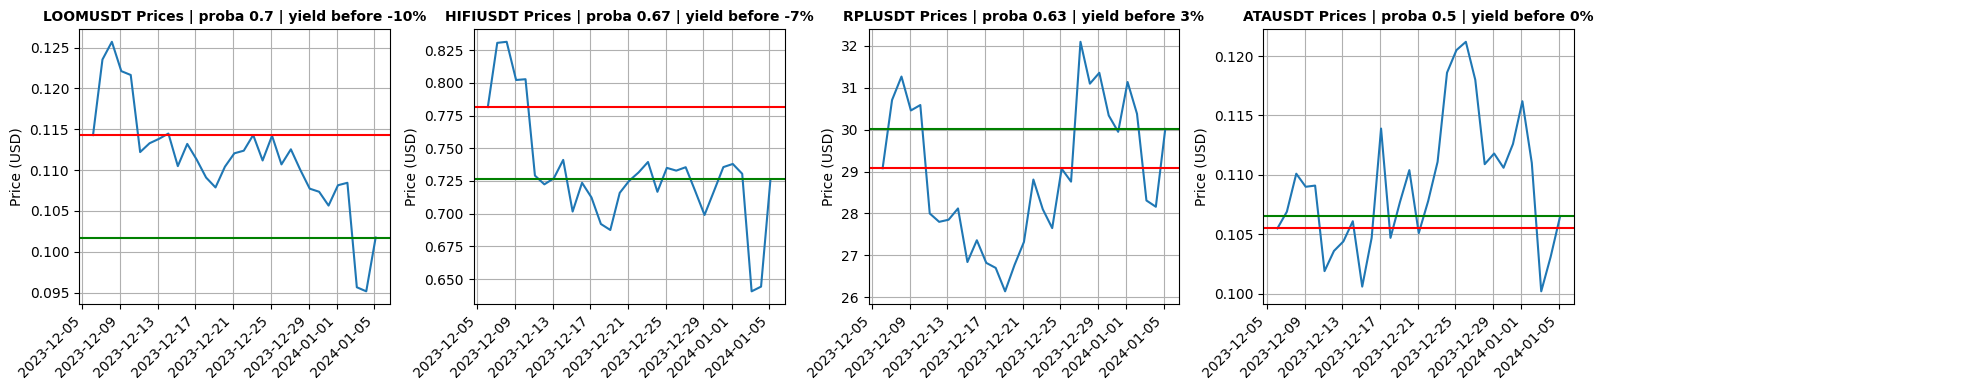

In [429]:
eval_model(exp_config=EXPERIMENT_CONFIG)

In [435]:
'\n'.join(best_symbols.Symbol.values.tolist())

'LOOMUSDT\nHIFIUSDT\nVICUSDT\nRPLUSDT\nATAUSDT'

In [281]:
BINANCE_SYMBOLS

array(['BTCUSDT', 'ETHUSDT', 'BNBUSDT', 'BCCUSDT', 'NEOUSDT', 'LTCUSDT',
       'QTUMUSDT', 'ADAUSDT', 'XRPUSDT', 'EOSUSDT', 'TUSDUSDT',
       'IOTAUSDT', 'XLMUSDT', 'ONTUSDT', 'TRXUSDT', 'ETCUSDT', 'ICXUSDT',
       'VENUSDT', 'NULSUSDT', 'VETUSDT', 'PAXUSDT', 'BCHABCUSDT',
       'BCHSVUSDT', 'USDCUSDT', 'LINKUSDT', 'WAVESUSDT', 'BTTUSDT',
       'USDSUSDT', 'ONGUSDT', 'HOTUSDT', 'ZILUSDT', 'ZRXUSDT', 'FETUSDT',
       'BATUSDT', 'XMRUSDT', 'ZECUSDT', 'IOSTUSDT', 'CELRUSDT',
       'DASHUSDT', 'NANOUSDT', 'OMGUSDT', 'THETAUSDT', 'ENJUSDT',
       'MITHUSDT', 'MATICUSDT', 'ATOMUSDT', 'TFUELUSDT', 'ONEUSDT',
       'FTMUSDT', 'ALGOUSDT', 'USDSBUSDT', 'GTOUSDT', 'ERDUSDT',
       'DOGEUSDT', 'DUSKUSDT', 'ANKRUSDT', 'WINUSDT', 'COSUSDT',
       'NPXSUSDT', 'COCOSUSDT', 'MTLUSDT', 'TOMOUSDT', 'PERLUSDT',
       'DENTUSDT', 'MFTUSDT', 'KEYUSDT', 'STORMUSDT', 'DOCKUSDT',
       'WANUSDT', 'FUNUSDT', 'CVCUSDT', 'CHZUSDT', 'BANDUSDT', 'BUSDUSDT',
       'BEAMUSDT', 'XTZUSDT', 'RENUSDT', 'RVN

In [285]:
eval_candels_df = compose_binance_candles_df(BINANCE_SYMBOLS, start_time='2023-10-10', end_time='2023-12-20')


# Generate features
print('Start to generate features')
eval_features_df = add_features(eval_candels_df, exp_config=EXPERIMENT_CONFIG)


# Load model
model = load(os.path.join(config.MODELS_PATH, "xgb_model_new.joblib"))

# Predict for today
print('Start to predict')
eval_features_df_today = eval_features_df.dropna()
eval_features_df_today.loc[:, 'proba'] = model.best_estimator_.predict_proba(eval_features_df_today.loc[:, model.feature_names_in_])[:, 1]
eval_features_df_today.loc[:, 'predict'] = model.best_estimator_.predict(eval_features_df_today.loc[:, model.feature_names_in_])


  0%|          | 0/494 [00:00<?, ?it/s]

Start to generate features


  0%|          | 0/396 [00:00<?, ?it/s]

Start to predict


/var/folders/jw/6fn4wc097x782s0059kltcsh0000gn/T/ipykernel_74452/1731832329.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_features_df_today.loc[:, 'proba'] = model.best_estimator_.predict_proba(eval_features_df_today.loc[:, model.feature_names_in_])[:, 1]
/var/folders/jw/6fn4wc097x782s0059kltcsh0000gn/T/ipykernel_74452/1731832329.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_features_df_today.loc[:, 'predict'] = model.best_estimator_.predict(eval_features_df_today.loc[:, model.featur

In [296]:
symb_df.head()

,Open,High,Low,Close,Volume,Symbol,cum_prod,yield_before_pump,Trailing_ATR,SuperTrend,MACD,MACD_Signal_Line,MACD_Bar_Charts,RSI,OBV_Volume_Ratio,Upper_distance,Lower_distance,CMF,Price_ROC,Volume_ROC,Volume_Ratio,Stoch_RSI_K,Stoch_RSI_D,Reg_Coef,RMSE,SuperTrend_lag_1,SuperTrend_lag_2,SuperTrend_lag_3,SuperTrend_lag_4,SuperTrend_lag_5,SuperTrend_lag_6,SuperTrend_lag_7,MACD_Signal_Line_lag_1,MACD_Signal_Line_lag_2,MACD_Signal_Line_lag_3,MACD_Signal_Line_lag_4,MACD_Signal_Line_lag_5,MACD_Signal_Line_lag_6,MACD_Signal_Line_lag_7,MACD_lag_1,MACD_lag_2,MACD_lag_3,MACD_lag_4,MACD_lag_5,MACD_lag_6,MACD_lag_7,MACD_Bar_Charts_lag_1,MACD_Bar_Charts_lag_2,MACD_Bar_Charts_lag_3,MACD_Bar_Charts_lag_4,MACD_Bar_Charts_lag_5,MACD_Bar_Charts_lag_6,MACD_Bar_Charts_lag_7,RSI_lag_1,RSI_lag_2,RSI_lag_3,RSI_lag_4,RSI_lag_5,RSI_lag_6,RSI_lag_7,OBV_Volume_Ratio_lag_1,OBV_Volume_Ratio_lag_2,OBV_Volume_Ratio_lag_3,OBV_Volume_Ratio_lag_4,OBV_Volume_Ratio_lag_5,OBV_Volume_Ratio_lag_6,OBV_Volume_Ratio_lag_7,Upper_distance_lag_1,Upper_distance_lag_2,Upper_distance_lag_3,Upper_distance_lag_4,Upper_distance_lag_5,Upper_distance_lag_6,Upper_distance_lag_7,Lower_distance_lag_1,Lower_distance_lag_2,Lower_distance_lag_3,Lower_distance_lag_4,Lower_distance_lag_5,Lower_distance_lag_6,Lower_distance_lag_7,CMF_lag_1,CMF_lag_2,CMF_lag_3,CMF_lag_4,CMF_lag_5,CMF_lag_6,CMF_lag_7,Price_ROC_lag_1,Price_ROC_lag_2,Price_ROC_lag_3,Price_ROC_lag_4,Price_ROC_lag_5,Price_ROC_lag_6,Price_ROC_lag_7,Volume_ROC_lag_1,Volume_ROC_lag_2,Volume_ROC_lag_3,Volume_ROC_lag_4,Volume_ROC_lag_5,Volume_ROC_lag_6,Volume_ROC_lag_7,Volume_Ratio_lag_1,Volume_Ratio_lag_2,Volume_Ratio_lag_3,Volume_Ratio_lag_4,Volume_Ratio_lag_5,Volume_Ratio_lag_6,Volume_Ratio_lag_7,Stoch_RSI_K_lag_1,Stoch_RSI_K_lag_2,Stoch_RSI_K_lag_3,Stoch_RSI_K_lag_4,Stoch_RSI_K_lag_5,Stoch_RSI_K_lag_6,Stoch_RSI_K_lag_7,Stoch_RSI_D_lag_1,Stoch_RSI_D_lag_2,Stoch_RSI_D_lag_3,Stoch_RSI_D_lag_4,Stoch_RSI_D_lag_5,Stoch_RSI_D_lag_6,Stoch_RSI_D_lag_7,Reg_Coef_lag_1,Reg_Coef_lag_2,Reg_Coef_lag_3,Reg_Coef_lag_4,Reg_Coef_lag_5,Reg_Coef_lag_6,Reg_Coef_lag_7,RMSE_lag_1,RMSE_lag_2,RMSE_lag_3,RMSE_lag_4,RMSE_lag_5,RMSE_lag_6,RMSE_lag_7,proba,predict
Time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-10-18 03:00:00+03:00,105.463183,102.534562,103.855422,101.173709,4169791.71,FLOWUSDT,0.0,-0.952381,0.492374,104.425926,1.174176,0.638179,0.535997,58.903532,2.937480,0.326555,0.398159,0.22187,-2.927928,2.402889,0.807328,51.571959,51.571959,0.0,0.0,105.503591,105.695913,103.032659,100.547435,97.464959,99.341244,99.341244,0.504179,0.310766,0.118246,-0.007811,-0.034786,-0.014981,0.000000,1.277835,1.080842,0.622478,0.100088,-0.114009,-0.074903,0.000000,0.773655,0.770076,0.504232,0.107899,-0.079223,-0.059923,0.000000,58.903532,58.903532,58.903532,58.903532,58.903532,58.903532,58.903532,4.032093,2.682906,2.297535,1.046070,0.084714,-1.000000,0.000000,0.326555,0.326555,0.326555,0.326555,0.326555,0.326555,0.326555,0.398159,0.398159,0.398159,0.398159,0.398159,0.398159,0.398159,0.22187,0.22187,0.22187,0.22187,0.22187,0.22187,0.22187,-1.769912,0.668151,4.418605,3.117506,0.240385,-0.952381,-0.952381,-46.684091,36.521847,-19.380188,83.880511,9.255467,-33.705243,-33.705243,0.772713,1.415445,1.084204,1.356862,0.766705,0.684934,1.000000,51.571959,51.571959,51.571959,51.571959,51.571959,51.571959,51.571959,51.571959,51.571959,51.571959,51.571959,51.571959,51.571959,51.571959,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.009863,0
2023-10-19 03:00:00+03:00,102.612827,100.691244,99.518072,99.061033,5918526.24,FLOWUSDT,0.0,-0.952381,0.603161,101.612560,0.911048,0.692753,0.218295,58.903532,1.069549,0.326555,0.398159,0.22187,-2.088167,41.938175,1.130202,51.571959,51.571959,0.0,0.0,104.425926,105.503591,105.695913,103.032659,100.547435,97.464959,99.341244,0.638179,0.504179,0.310766,0.118246,-0.007811,-0.034786,-0.014981,1.174176,1.277835,1.080842,0.622478,0.100088,-0.

In [319]:
eval_features_df_today.sort_index().groupby('Symbol').Close.shift(-10)

Time
2023-10-18 03:00:00+03:00    124.428078
2023-10-18 03:00:00+03:00    112.861379
2023-10-18 03:00:00+03:00    125.224455
2023-10-18 03:00:00+03:00    113.321570
2023-10-18 03:00:00+03:00    105.534496
                                ...    
2024-01-05 03:00:00+03:00           NaN
2024-01-05 03:00:00+03:00           NaN
2024-01-05 03:00:00+03:00           NaN
2024-01-05 03:00:00+03:00           NaN
2024-01-05 03:00:00+03:00           NaN
Name: Close, Length: 30420, dtype: float64

In [320]:
eval_features_df_today = eval_features_df_today.sort_values('Symbol')
eval_features_df_today['lead_10_price'] = eval_features_df_today.groupby('Symbol').Close.shift(-10)
eval_features_df_today['yield'] = (eval_features_df_today['lead_10_price'] / eval_features_df_today['Close'] - 1) * 100

In [326]:
eval_features_df_today.loc[eval_features_df_today['predict'] == 1,['Close', 'Symbol', 'predict', 'yield']]['yield']

count    986.000000
mean      13.450075
std       44.323278
min      -65.320122
25%       -5.599027
50%        3.718325
75%       16.615199
max      559.749145
Name: yield, dtype: float64

count    400.000000
mean      13.383082
std       46.523928
min      -65.320122
25%       -6.741686
50%        1.814674
75%       17.587111
max      436.284722
Name: yield, dtype: float64

depo 92
profit 107.06465413215423
profit 116.37462405668938%


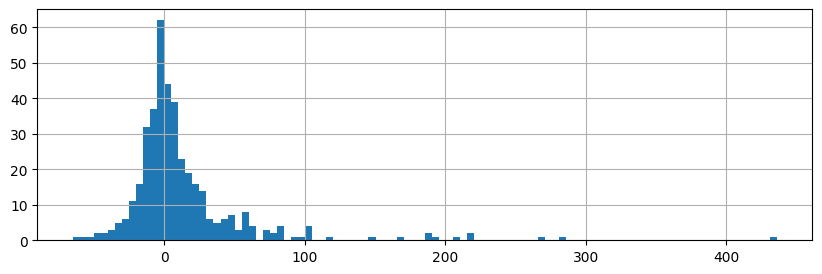

In [371]:
yield_lists = eval_features_df_today.loc[(eval_features_df_today['predict'] == 1) & (eval_features_df_today['proba'] < 0.60),['Close', 'Symbol', 'predict', 'yield']]['yield']

print(yield_lists.describe())
fig = plt.figure(figsize=(10, 3))
yield_lists.hist(bins=100)

cost_per_tr = 2
max_tr_per_day = yield_lists.groupby(yield_lists.index).count().max()
depo = max_tr_per_day * cost_per_tr
profit = (cost_per_tr * yield_lists / 100).sum()
print(f"\ndepo {depo}")
print(f'profit {profit}')
print(f'profit {profit/depo * 100}%')

depo 376
profit 265.2354727511573
profit 70.54134913594609%


In [350]:
yield_lists.groupby(yield_lists.index).count().max()

188

In [ ]:
for i, symb in enumerate(eval_features_df_today.Symbol.unique()):
    symb_df = eval_features_df_today[eval_features_df_today.Symbol == symb].copy()
    symb_df['lead_10_price'] = symb_df.sort_index().groupby('Symbol').Close.shift(-10)
    symb_df['yield'] = (symb_df['lead_10_price'] / symb_df['Close'] - 1) * 100
    
    fig = plt.figure(figsize=(15, 3))
    symb_df = symb_df.dropna()
    symb_df.Close.plot()
    for pump_index in symb_df[symb_df.predict == 1].index:
        plt.axvline(x=pump_index)
        proba = int(symb_df.loc[pump_index,'proba'] * 100) / 100
        yield_ = int(symb_df.loc[pump_index,'yield'] * 100) / 100
        plt.text(pump_index, symb_df.Close.max() * 0.9,  f'{proba}', color='red', fontsize=10)
        plt.text(pump_index, symb_df.Close.max() * 0.8,  f'{yield_}%', color='red', fontsize=10)
    plt.title(symb)
    plt.show()
    if i >= 20:
        break

In [ ]:
def get_fear_and_greed_index(candels_df):
    
    response = requests.get("https://api.alternative.me/fng/?limit=0&format=json&date_format=world").json()
    
    fng = pd.DataFrame(response["data"]).set_index("timestamp")["value"].to_frame("fear_and_greed")
    fng.index = pd.DatetimeIndex(fng.index, tz="UTC").tz_convert(config.DEFAULT_TZ)
    
    candels_df = candels_df.merge(fng, right_index=True, left_index=True, how="left")
    
    return

In [10]:
import requests
response = requests.get("https://api.alternative.me/fng/?limit=0&format=json&date_format=world").json()

In [ ]:
start_date = pd.Timestamp(start_date)

In [18]:
fng = pd.DataFrame(response["data"]).set_index("timestamp")["value"]

In [16]:
(pd.Timestamp("2024-03-01") - pd.Timestamp("2018-01-01")).days

2251

In [30]:
fng.index = pd.DatetimeIndex(fng.index, tz="UTC").tz_convert(config.DEFAULT_TZ)

In [16]:
def get_fear_and_greed_index(candels_df):
    
    response = requests.get("https://api.alternative.me/fng/?limit=0&format=json&date_format=world").json()
    
    fng = pd.DataFrame(response["data"]).set_index("timestamp")["value"].to_frame("fear_and_greed")
    fng.index = pd.DatetimeIndex(fng.index, tz="UTC").tz_convert(config.DEFAULT_TZ)
    
    candels_df = candels_df.merge(fng, right_index=True, left_index=True, how="left", copy=False)
    
    return candels_df

In [19]:
candels_df = get_fear_and_greed_index(candels_df)

In [20]:
candels_df

,Open,High,Low,Close,Volume,Symbol,fear_and_greed
Time,,,,,,,
2018-01-02 00:00:00+00:00,13382.160000,15473.490000,12890.020000,14675.110000,2.007809e+04,BTCUSDT,30
2018-01-02 00:00:00+00:00,78.255000,96.997000,78.246000,89.696000,2.006429e+05,NEOUSDT,30
2018-01-02 00:00:00+00:00,222.620000,256.490000,222.620000,247.330000,6.329313e+04,LTCUSDT,30
2018-01-02 00:00:00+00:00,8.450000,9.113300,8.092200,8.715000,1.262633e+06,BNBUSDT,30
2018-01-02 00:00:00+00:00,754.990000,899.500000,749.060000,855.280000,1.132578e+05,ETHUSDT,30
...,...,...,...,...,...,...,...
2024-03-02 00:00:00+00:00,115.040000,122.970000,114.220000,119.470000,2.195704e+05,TRBUSDT,60
2024-03-02 00:00:00+00:00,0.000566,0.000680,0.000542,0.000632,2.698181e+11,1000SATSUSDT,60
2024-03-02 00:00:00+00:00,1.602000,1.739000,1.557000,1.630000,1.230524e+07,SUSHIUSDT,60
